## 기초 작업

### 데이터 불러오기

In [2]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
# 데이터 불러오기
root = './data/'

# 원본
train = pd.read_csv(root + 'train.csv')
stores = pd.read_csv(root + 'stores.csv')
features = pd.read_csv(root + 'features.csv')
test = pd.read_csv(root + 'test.csv')

train.shape, stores.shape, features.shape

((421570, 5), (45, 3), (8190, 12))

In [4]:
# 데이터 결합
# train + stores
wal_df = pd.merge(train, stores, how = 'left', on = 'Store')

# train(new) + features
wal_df = pd.merge(wal_df, features, how = 'left', on = ['Store', 'Date'])

# holiday 컬럼 처리
wal_df = wal_df.drop(columns='IsHoliday_x')
wal_df = wal_df.rename(columns={'IsHoliday_y':'IsHoliday'})

# 결합 원본
wal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     150681 non-null  float64
 9   MarkDown2     111248 non-null  float64
 10  MarkDown3     137091 non-null  float64
 11  MarkDown4     134967 non-null  float64
 12  MarkDown5     151432 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


#### 전처리

In [5]:
df = wal_df.copy()

In [6]:
# 시계열 데이터 처리 및 연,월,일 데이터 추가
df["Date"] = pd.to_datetime(df["Date"])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Week'] = df['Date'].apply(lambda x: x.isocalendar()[1])

In [7]:
# 팀원들과 순서 일치
df = df.sort_values(['Store','Year','Month','Day','Dept']).reset_index()
df = df.iloc[:,1:]
df.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Week
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,2,5,5
1,1,2,2010-02-05,50605.27,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,2,5,5
2,1,3,2010-02-05,13740.12,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,2,5,5
3,1,4,2010-02-05,39954.04,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,2,5,5
4,1,5,2010-02-05,32229.38,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,2,5,5


### EDA

#### 히트맵

C:\Users\tkwi5\anaconda3\envs\sparta\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tkwi5\anaconda3\envs\sparta\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


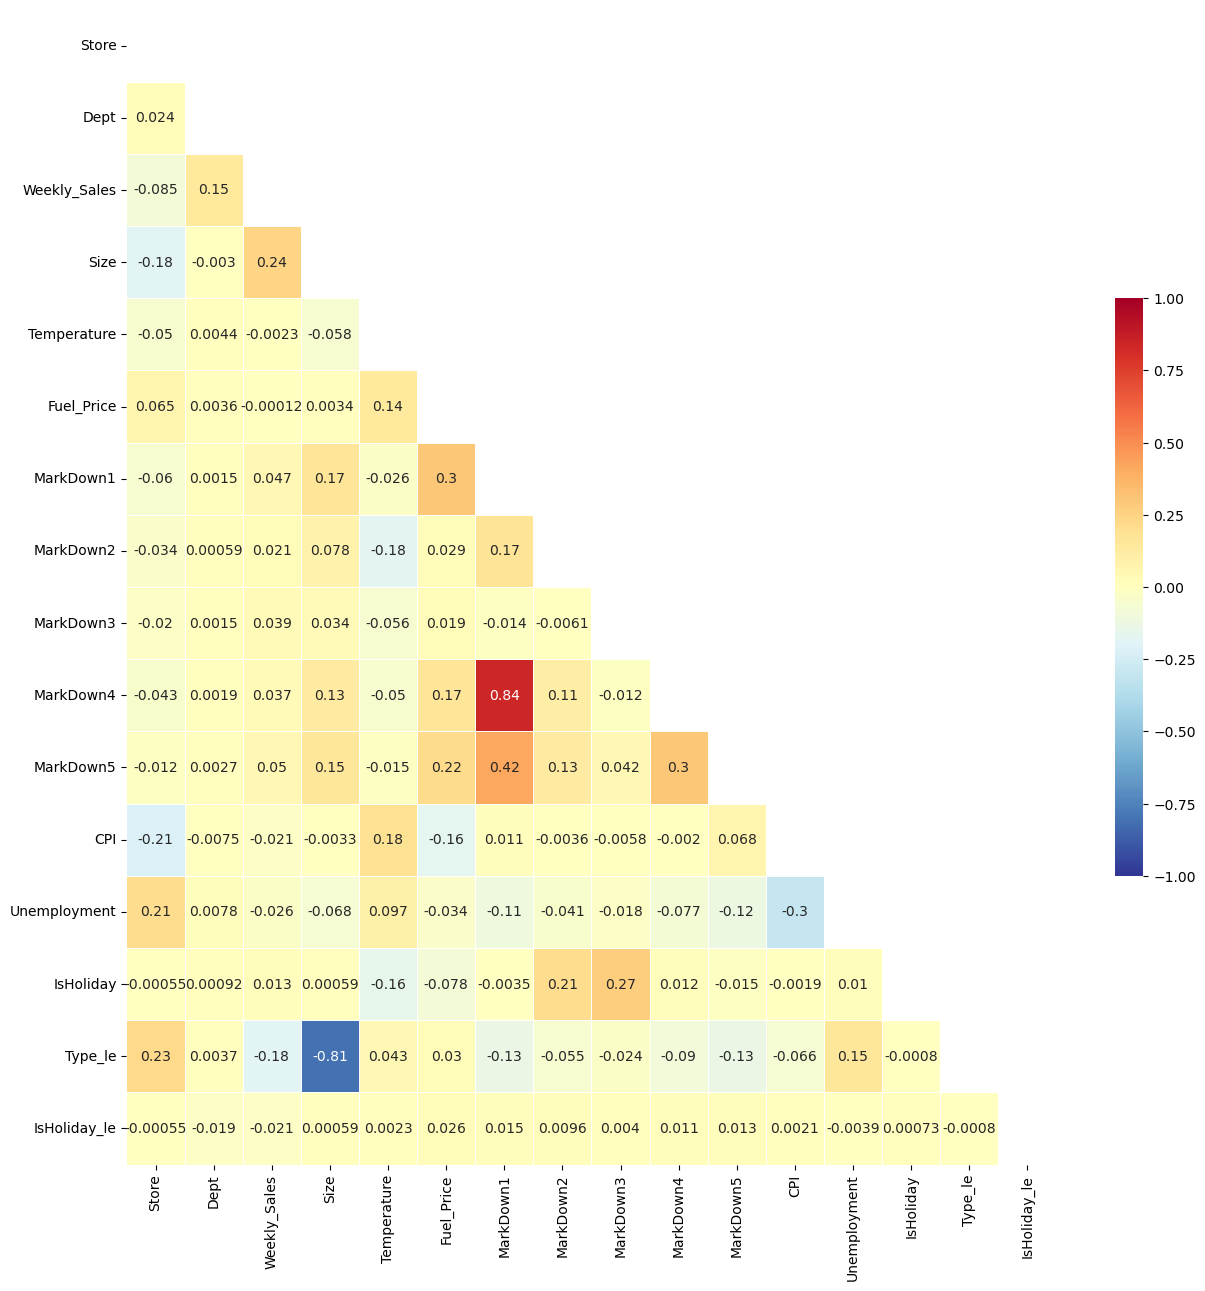

In [28]:
# 원본 wal_df
# 결측치 러치
wal_df_fna = wal_df.fillna(0)
#Type label encoding
le = LabelEncoder()
le.fit(wal_df_fna[['Type']])
wal_df_fna['Type_le'] = le.transform(df['Type'])
#IsHoliday label encoding
le.fit(wal_df_fna[['IsHoliday']])
wal_df_fna['IsHoliday_le'] = le.transform(df['IsHoliday'])
# Markdown 전처리
wal_df_cor = wal_df_fna.corr(numeric_only=True)
# 히트맵 확인
fig, ax = plt.subplots( figsize=(15,15) )

# 삼각형 마스크(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(wal_df_cor, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(wal_df_cor, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시
            mask=mask,      # 표시하지 않을 마스크 부분 지정
            linewidths=.5,  # 경계면 실선으로 구분
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

#### Regular VS Holiday

In [ ]:
# df1 = wal_df.groupby(['Store', 'IsHoliday']).size().unstack(1)

# #stacked=True 로 설정하면 누적그래프를 그릴 수 있습니다. 
# plt.figure(figsize= (30,15))

# stacked_plot= df1.plot(kind='bar', stacked=True, color = ['#0071ce','#ffc220'])
# plt.title("Number of Dates")
# plt.xlabel("Store")
# plt.xticks(rotation = 45)
# plt.ylabel("Count")

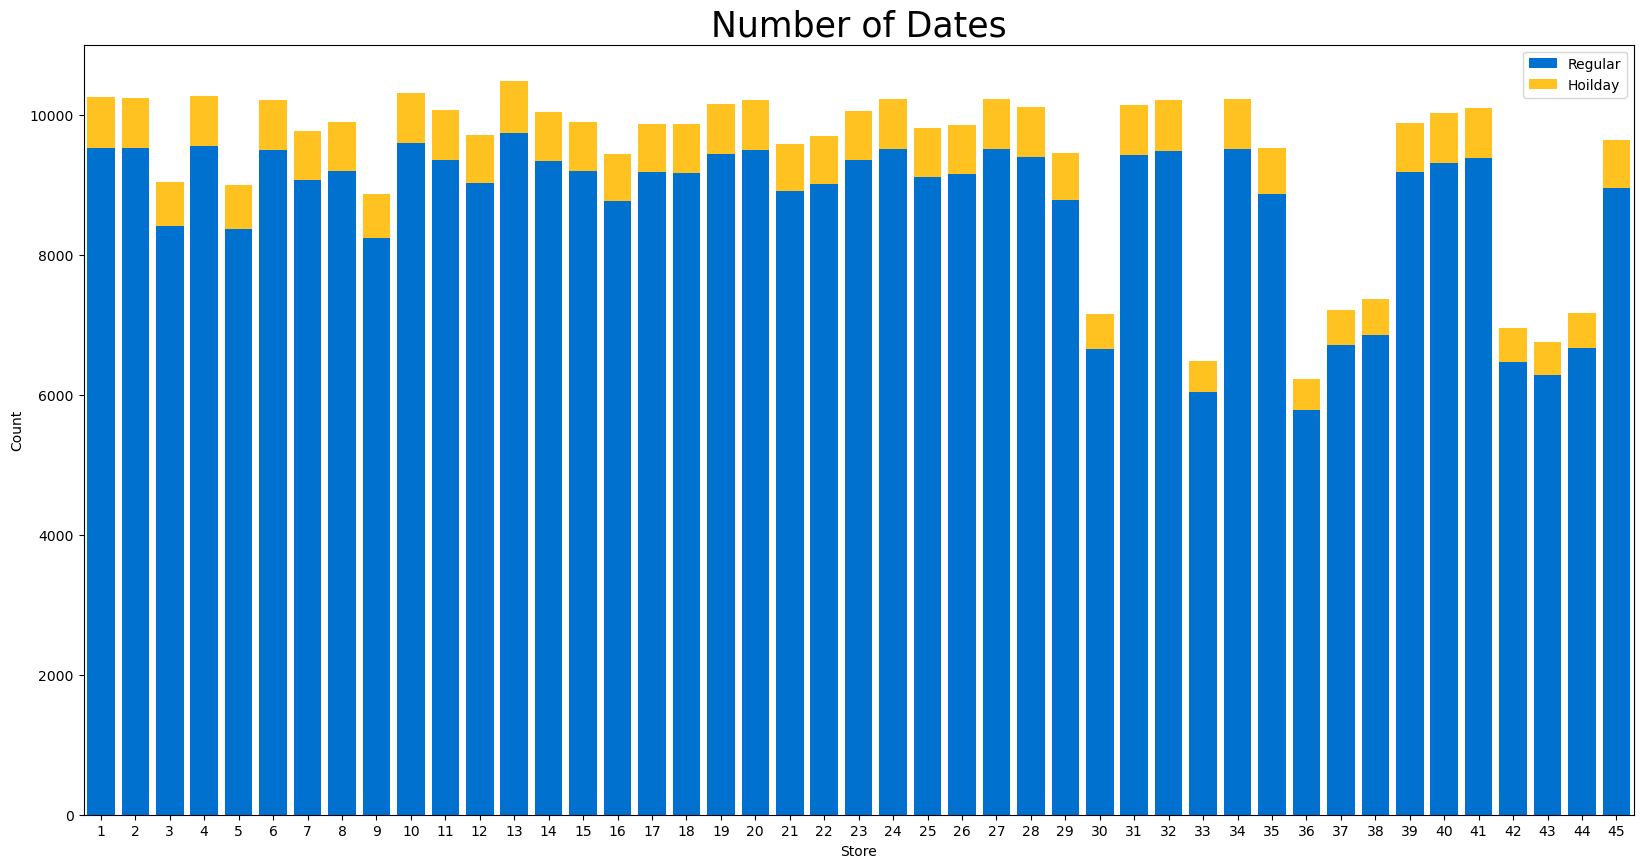

In [315]:
# - ['#0071ce','#ffc220']
plt.figure(figsize=(20,10))
gb = df.groupby('Store')['IsHoliday_le'].value_counts()
gab = gb.unstack().reset_index()
sns.barplot(gab, x='Store', y=0, color='#0071ce', label='Regular', saturation=1)
sns.barplot(gab, x='Store', y=1, color='#ffc220', label='Hoilday', bottom=gab[0], saturation=1)
plt.ylabel('Count')
plt.title('Number of Dates', fontsize=25)
plt.savefig('그래프.png')
plt.show()

#### 분포 파악 및 스케일링 방안

array([[<Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'Temperature'}>],
       [<Axes: title={'center': 'Fuel_Price'}>,
        <Axes: title={'center': 'CPI'}>],
       [<Axes: title={'center': 'Unemployment'}>, <Axes: >]], dtype=object)

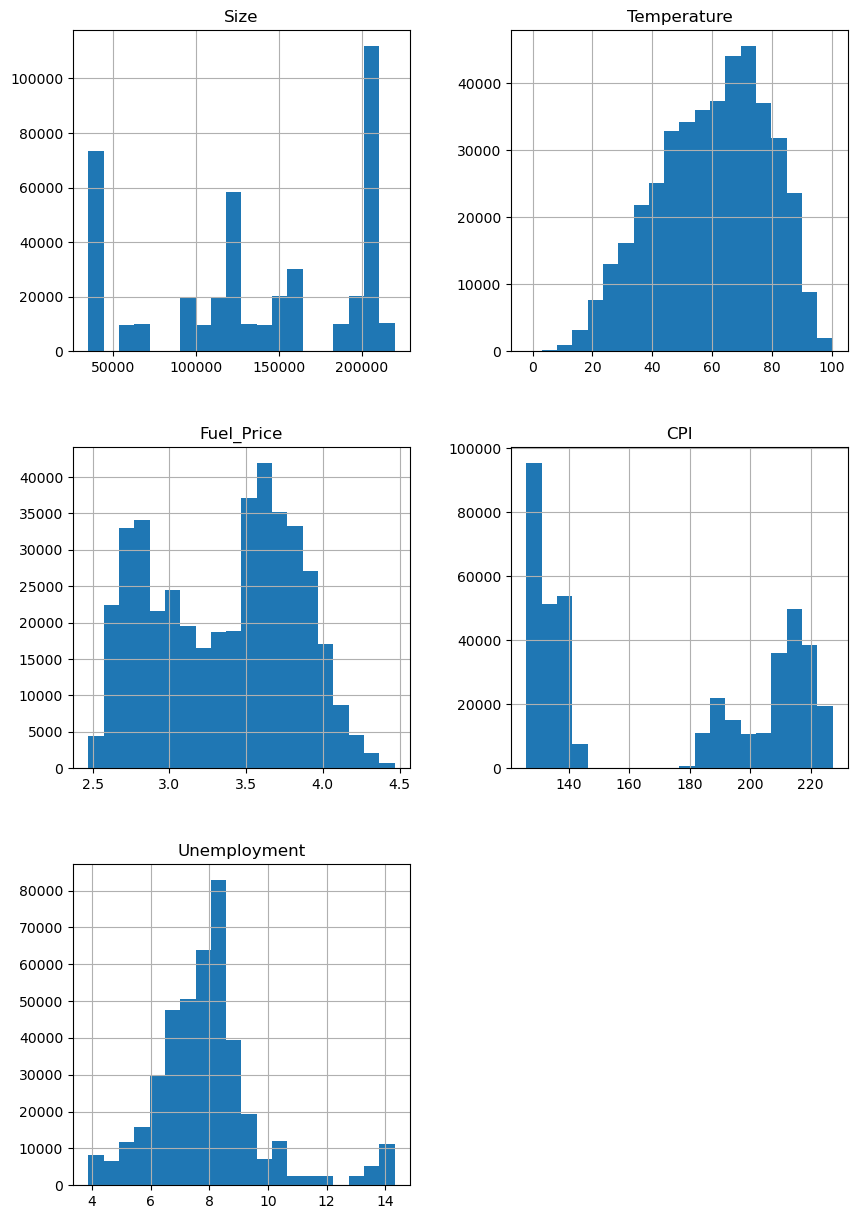

In [30]:
wal_df[['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].hist(figsize=(10, 15), bins=20)

#### 이상치 탐색

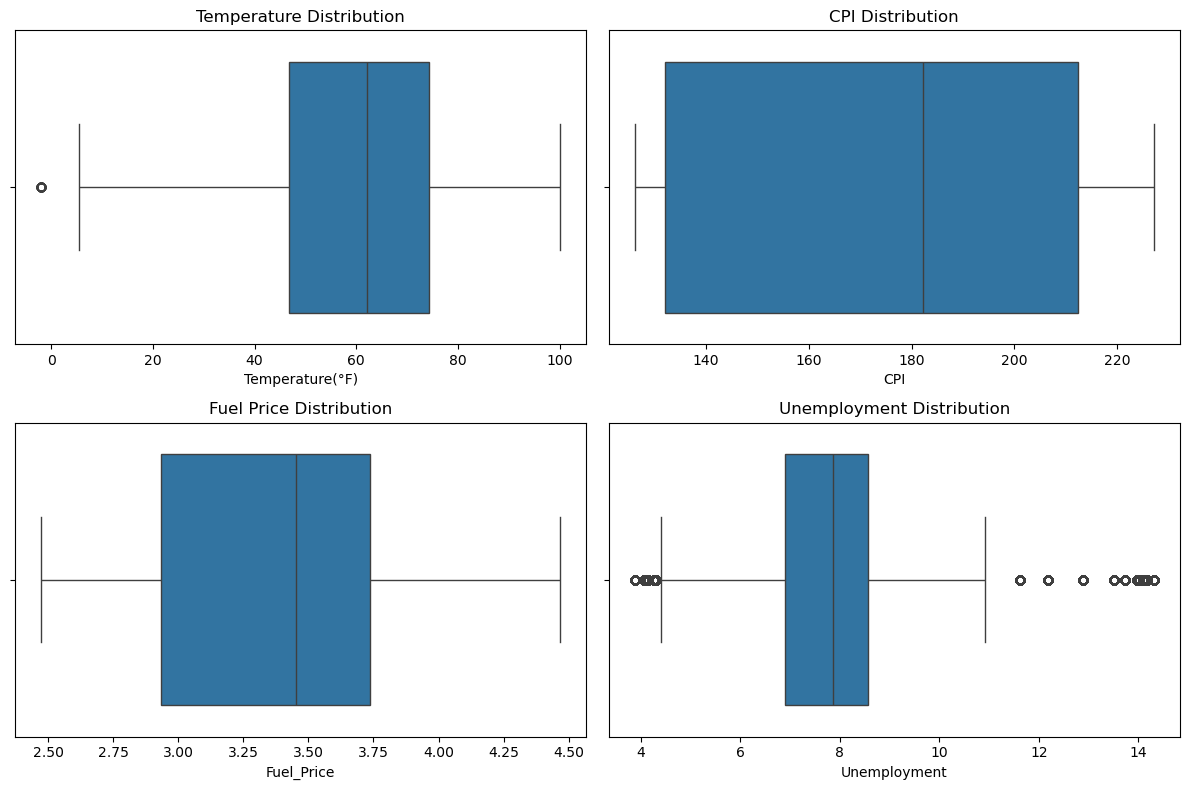

In [31]:
# boxplot
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.boxplot(data=wal_df, x='Temperature')
plt.title('Temperature Distribution')
plt.xlabel('Temperature(°F)')

plt.subplot(2,2,2)
sns.boxplot(data=wal_df, x='CPI')
plt.title('CPI Distribution')

plt.subplot(2,2,3)
sns.boxplot(data=wal_df, x='Fuel_Price')
plt.title('Fuel Price Distribution')

plt.subplot(2,2,4)
sns.boxplot(data=wal_df, x='Unemployment')
plt.title('Unemployment Distribution')

plt.tight_layout()

#### Holiday 데이터

Text(0.5, 1.0, 'Regular vs Holiday(Weekly Sales)')

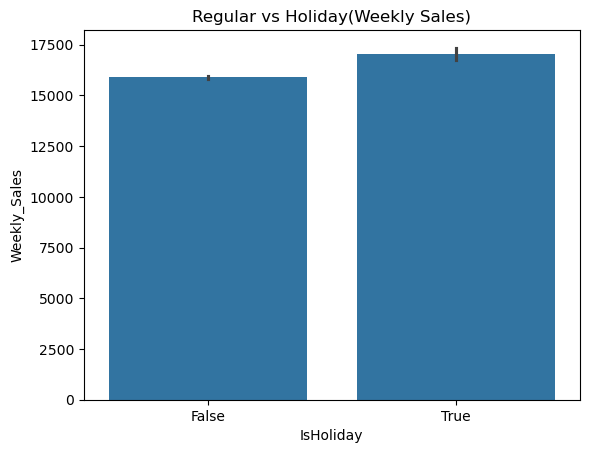

In [32]:
sns.barplot(data = df, x = 'IsHoliday', y = 'Weekly_Sales',estimator='mean')
plt.title('Regular vs Holiday(Weekly Sales)')

#### hoilday 별 mean sales

C:\Users\tkwi5\AppData\Local\Temp\ipykernel_33220\86980337.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_holiday_sum_sales, x='holiday_type', y='Weekly_Sales',
C:\Users\tkwi5\AppData\Local\Temp\ipykernel_33220\86980337.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x/1000:,.0f}' for x in current_values])


Text(0, 0.5, 'Weekly Sales($ 1k)')

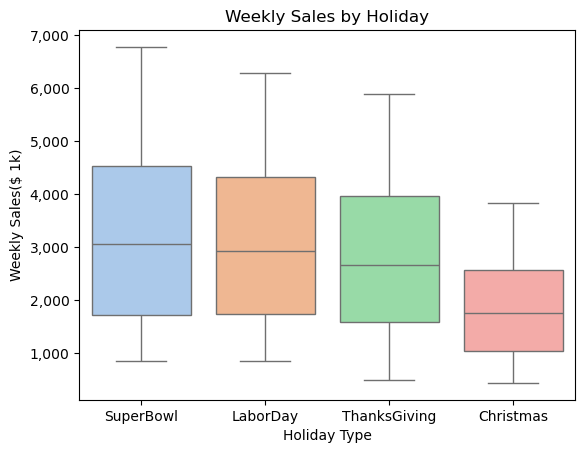

In [34]:
# holiday 데이터만 보기
mask = (wal_df['IsHoliday']==True)
df_holiday = wal_df[mask].reset_index()

# Month 추출
def extract_month(df,colname):
    from datetime import datetime
    df['Month'] = df[colname].apply(lambda x: pd.to_datetime(x).month)
    
extract_month(df_holiday,'Date')

# holiday type 구분
df_holiday['holiday_type'] = df_holiday['Month'].apply(lambda x: 
    'SuperBowl' if x == 2 else
    'LaborDay' if x == 9 else
    'ThanksGiving' if x == 11 else
    'Christmas' if x == 12 else
    'None')

df_holiday_sum_sales = df_holiday.groupby(['holiday_type','Store'])['Weekly_Sales'].sum().reset_index()

sns.boxplot(data = df_holiday_sum_sales, x='holiday_type', y='Weekly_Sales',
            order = ['SuperBowl','LaborDay','ThanksGiving','Christmas'], palette='pastel')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{x/1000:,.0f}' for x in current_values])
plt.title('Weekly Sales by Holiday')
plt.xlabel('Holiday Type')
plt.ylabel('Weekly Sales($ 1k)')

#### Weekly Sales Trends

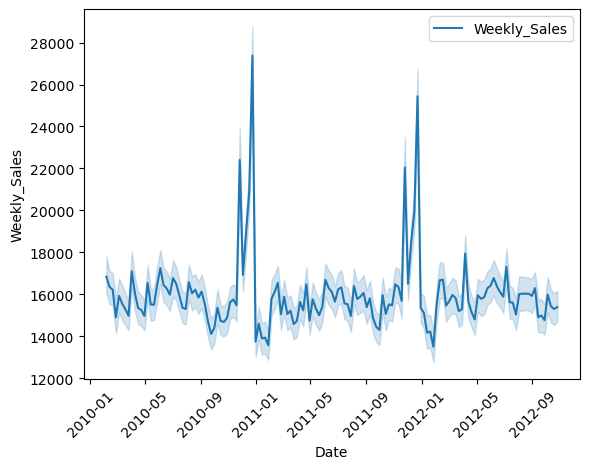

In [35]:
cols = ['Weekly_Sales']
for i in cols:
  sns.lineplot(df, x='Date', y=i, label=i)

plt.xticks(rotation=45)
plt.show()

### 함수(기타)

#### 평가 함수

In [26]:
def WMAE(y_true, y_pred, X_test):
    w = X_test['IsHoliday_le'].apply(lambda x: 5 if x==1 else 1)
    return np.round(np.sum(w*abs(y_true - y_pred)) / (np.sum(w)), 4)

def ER(y_true, y_pred, bin=30000):
    # y_true가 0인 데이터 제외 (walmart의 test데이터의 경우 18개)
    df_y = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df_y = df_y[df_y['y_true'] != 0]

    # bin 기준으로 오차비율 확인
    # 하위
    y_true = df_y.loc[df_y['y_true']<=bin,'y_true']
    y_pred = df_y.loc[df_y['y_true']<=bin,'y_pred']
    ER_low = np.round(np.mean(abs((y_true - y_pred)/y_true)), 4)

    # 상위
    y_true = df_y.loc[df_y['y_true']>bin,'y_true']
    y_pred = df_y.loc[df_y['y_true']>bin,'y_pred']
    ER_high = np.round(np.mean(abs((y_true - y_pred)/y_true)), 4)
    return (ER_low, ER_high)

def get_score(model, y_true, y_pred, X_test, bin=30000):
    model_name = ''.join(filter(str.isalpha, str(type(model)).split('.')[-1]))
    wmae = WMAE(y_true, y_pred, X_test)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    er = ER(y_true, y_pred, bin)
    print(f'{model_name}\nWMAE : {wmae}\nRMSE : {rmse:.4f}\nR2 : {r2:.4f}\nER(low,high) : {er}  기준 : {bin}')

## 모델 학습

#### 전처리

In [8]:
## 인코딩
# 라벨 인코딩 : IsHoliday, Year
le1 = LabelEncoder()
le2 = LabelEncoder()

df['Year_le'] = le1.fit_transform(df['Year'])
df['IsHoliday_le'] = le2.fit_transform(df['IsHoliday'])

print(le1.classes_, df['Year_le'].unique())
print(le2.classes_, df['IsHoliday_le'].unique())

[2010 2011 2012] [0 1 2]
[False  True] [0 1]


In [9]:
## 스케일링
# stores 원본 테이블에서 size fit
sd_size = StandardScaler()
sd_size.fit(stores[['Size']])

for i in range(len(sd_size.mean_)):
    print(f'{sd_size.feature_names_in_[i]} 평균 : {sd_size.mean_[i]:.2f}, 표준편차 : {sd_size.scale_[i]:.2f}')

# features 원본 테이블에서 features fit
feature_cols = ['Temperature','Fuel_Price','CPI','Unemployment']
sd_feature = StandardScaler()
sd_feature.fit(features[feature_cols])
for i in range(len(sd_feature.mean_)):
    print(f'{sd_feature.feature_names_in_[i]} 평균 : {sd_feature.mean_[i]:.2f}, 표준편차 : {sd_feature.scale_[i]:.2f}')

Size 평균 : 130287.60, 표준편차 : 63112.12
Temperature 평균 : 59.36, 표준편차 : 18.68
Fuel_Price 평균 : 3.41, 표준편차 : 0.43
CPI 평균 : 172.46, 표준편차 : 39.74
Unemployment 평균 : 7.83, 표준편차 : 1.88


In [10]:
# fit한 스케일러들로 df 컬럼들 transform
feature_names = ['Temperature_sd','Fuel_Price_sd','CPI_sd','Unemployment_sd']
df['Size_sd'] = sd_size.transform(df[['Size']])
df[feature_names] = sd_feature.transform(df[feature_cols])

df.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Month,Day,Week,Year_le,IsHoliday_le,Size_sd,Temperature_sd,Fuel_Price_sd,CPI_sd,Unemployment_sd
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,NaN,NaN,...,2,5,5,0,0,0.333175,-0.912661,-1.933624,0.972312,0.148726
1,1,2,2010-02-05,50605.27,A,151315,42.31,2.572,NaN,NaN,...,2,5,5,0,0,0.333175,-0.912661,-1.933624,0.972312,0.148726
2,1,3,2010-02-05,13740.12,A,151315,42.31,2.572,NaN,NaN,...,2,5,5,0,0,0.333175,-0.912661,-1.933624,0.972312,0.148726
3,1,4,2010-02-05,39954.04,A,151315,42.31,2.572,NaN,NaN,...,2,5,5,0,0,0.333175,-0.912661,-1.933624,0.972312,0.148726
4,1,5,2010-02-05,32229.38,A,151315,42.31,2.572,NaN,NaN,...,2,5,5,0,0,0.333175,-0.912661,-1.933624,0.972312,0.148726


### 회귀 머신러닝 version_1

#### 선형 회귀 1회차

##### 데이터 셋 분리

In [38]:
X1 = df[['Store','Dept','Year_le','Month','Day','IsHoliday_le','Size_sd','Temperature_sd','Fuel_Price_sd','CPI_sd','Unemployment_sd']]
y = df['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X1_train.shape, X1_test.shape, y_train.shape, y_test.shape)

(295099, 11) (126471, 11) (295099,) (126471,)


Text(0.5, 1.0, 'X_test Holiday Count')

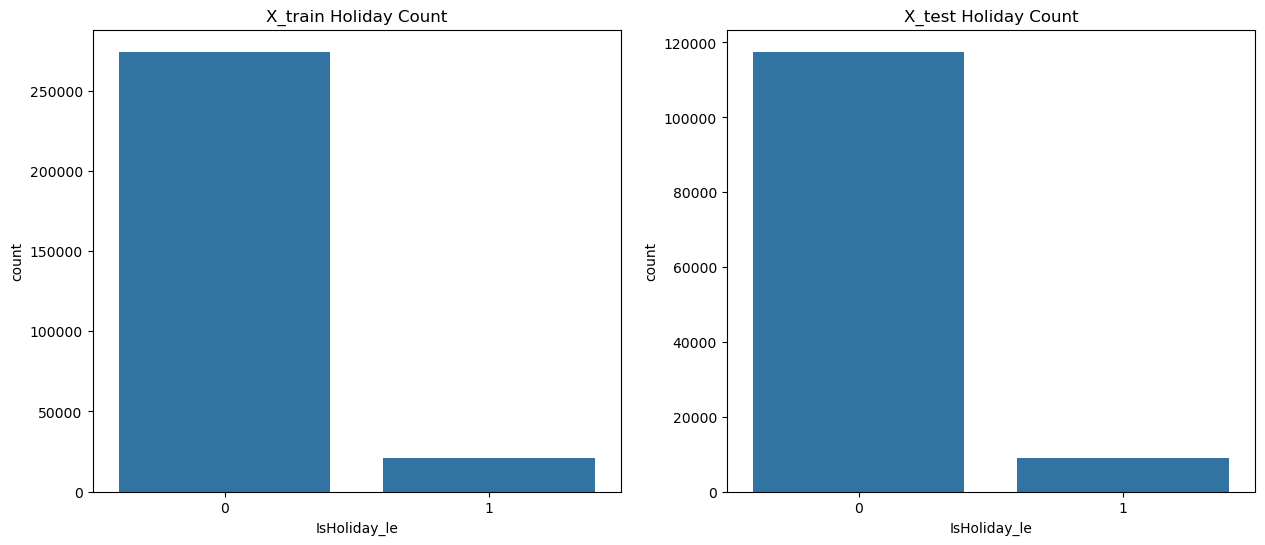

In [39]:
# Hoilday 분포 확인
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(X1_train, x='IsHoliday_le')
plt.title('X_train Holiday Count')

plt.subplot(1,2,2)
sns.countplot(X1_test, x='IsHoliday_le')
plt.title('X_test Holiday Count')

##### 모델 학습

In [42]:
## Linear Regression
model_lr1 = LinearRegression()
model_lr1.fit(X1_train, y_train)

LinearRegression()

In [43]:
# predict
lr1_pred = model_lr1.predict(X1_test)
lr1_pred[:5]

array([21286.6243299 , 20112.56404207, 26913.25041471, 10210.05551675,
       11425.07799562])

##### 모델 평가

In [46]:
# WMAE, RMSE, R2, ER
get_score(model_lr1, y_test, lr1_pred, X1_test)

LinearRegression
WMAE : 14793.8502
RMSE : 21663.8066
R2 : 0.0845
ER(low,high) : (580.1122, 0.6102)  기준 : 30000


#### 랜덤 포레스트 회귀 1회차

##### 모델 학습

In [47]:
## RandomForest
model_rf1 = RandomForestRegressor(random_state=73)
model_rf1.fit(X1_train,y_train)

RandomForestRegressor(random_state=73)

In [48]:
# predict
rf1_pred = model_rf1.predict(X1_test)
rf1_pred[:5]

array([ 11031.7779,   3129.5854, 109471.8277,  32768.9488,  33939.5829])

##### 모델 평가

In [50]:
# WMAE, RMSE, R2, ER
get_score(model_rf1, y_test, rf1_pred, X1_test)

RandomForestRegressor
WMAE : 1602.6524
RMSE : 3604.8407
R2 : 0.9747
ER(low,high) : (6.7244, 0.0733)  기준 : 30000


In [51]:
# 모델 중요도
model_rf1.feature_importances_

array([6.74069793e-02, 6.27233330e-01, 6.02092557e-04, 3.03686967e-02,
       2.36928926e-02, 2.84217652e-03, 1.91382881e-01, 1.19177638e-02,
       5.09679522e-03, 2.72745367e-02, 1.21818555e-02])

In [52]:
X1.columns

Index(['Store', 'Dept', 'Year_le', 'Month', 'Day', 'IsHoliday_le', 'Size_sd',
       'Temperature_sd', 'Fuel_Price_sd', 'CPI_sd', 'Unemployment_sd'],
      dtype='object')

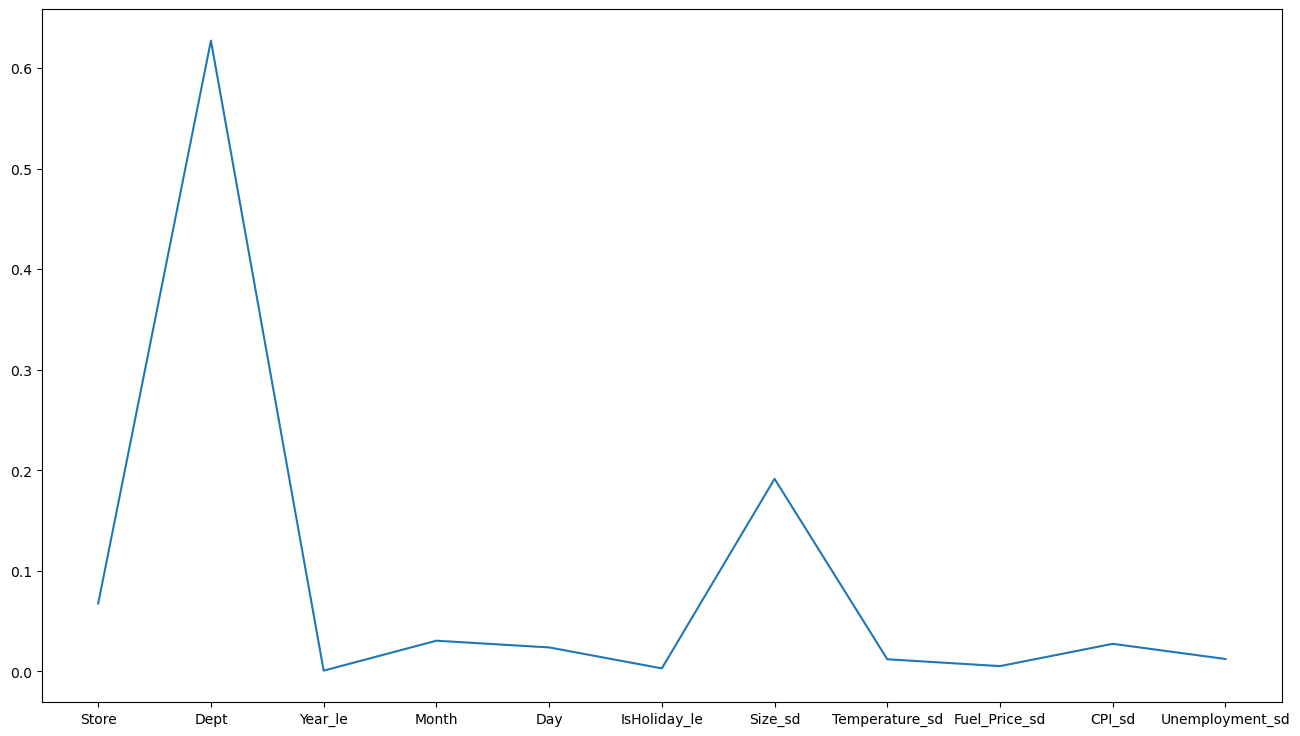

In [53]:
# 중요도 그래프 확인
plt.figure(figsize=(16,9))
plt.plot(X1.columns, model_rf1.feature_importances_);

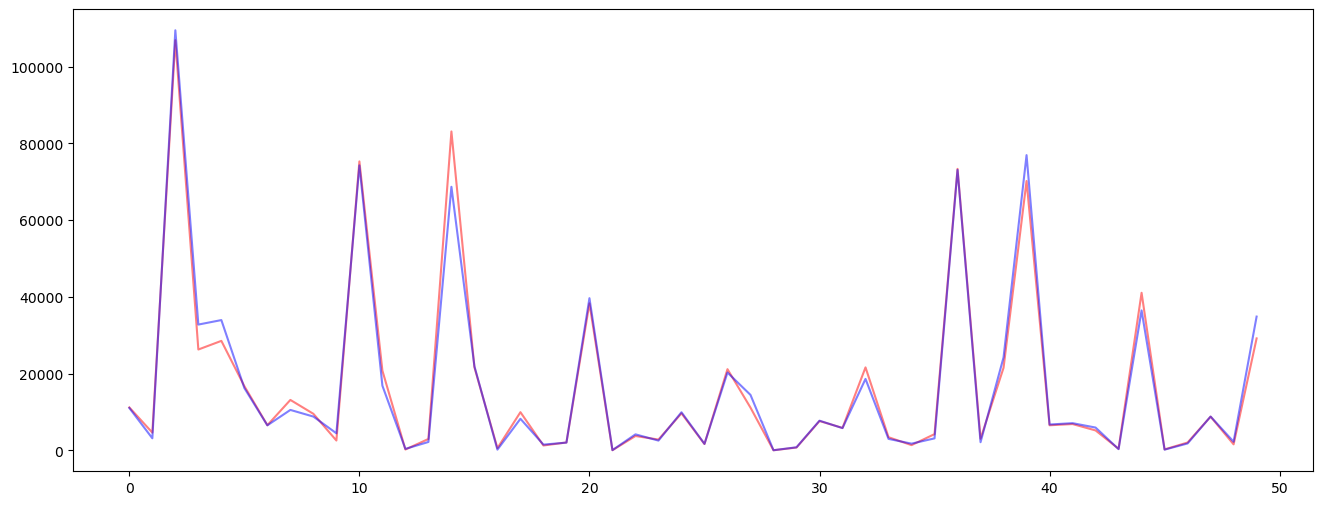

In [54]:
# 예측 그래프 확인 
plt.figure(figsize=(16,6))
plt.plot(X1_test[:50].reset_index().index, y_test[:50], alpha=0.5, color='red')
plt.plot(X1_test[:50].reset_index().index, rf1_pred[:50], alpha=0.5, color='blue');

#### GBR, XGB

In [55]:
model_GBR1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=73)
model_xgb1 = XGBRegressor(random_state= 73)

model_GBR1.fit(X1_train,y_train)
model_xgb1.fit(X1_train,y_train)

GBR1_pred = model_GBR1.predict(X1_test)
xgb1_pred = model_xgb1.predict(X1_test)

TypeError: get_score() missing 1 required positional argument: 'X_test'

In [56]:
get_score(model_GBR1, y_test, GBR1_pred, X1_test)
get_score(model_xgb1, y_test, xgb1_pred, X1_test)

GradientBoostingRegressor
WMAE : 7143.3501
RMSE : 11529.9645
R2 : 0.7407
ER(low,high) : (198.0211, 0.2996)  기준 : 30000
XGBRegressor
WMAE : 3264.2371
RMSE : 5576.5045
R2 : 0.9393
ER(low,high) : (65.3675, 0.1309)  기준 : 30000


### 회귀 머신러닝 version_2

#### 데이터 셋 분리

In [57]:
X2 = df[['Store','Dept','Year_le','Week','IsHoliday_le','Size_sd','Temperature_sd','Fuel_Price_sd','CPI_sd','Unemployment_sd']]
y = df['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X2_train.shape, X2_test.shape, y_train.shape, y_test.shape)

(295099, 10) (126471, 10) (295099,) (126471,)


#### 선형 회귀 2회차

##### 모델 학습

In [58]:
## Linear Regression
model_lr2 = LinearRegression()
model_lr2.fit(X2_train, y_train)

LinearRegression()

In [59]:
# predict
lr2_pred = model_lr2.predict(X2_test)
lr2_pred[:5]

array([21361.46425036, 19906.28718965, 26724.68142263,  9830.22759436,
       11219.97608647])

##### 모델 평가

In [61]:
# WMAE, RMSE, R2, ER
get_score(model_lr2, y_test, lr2_pred, X2_test)

LinearRegression
WMAE : 14792.4911
RMSE : 21664.3665
R2 : 0.0845
ER(low,high) : (579.6933, 0.6102)  기준 : 30000


#### 랜덤 포레스트 회귀 2회차

##### 모델 학습

In [62]:
model_rf2 = RandomForestRegressor(random_state=73)
model_rf2.fit(X2_train,y_train)

RandomForestRegressor(random_state=73)

In [63]:
# predict
rf2_pred = model_rf2.predict(X2_test)
rf2_pred[:5]

array([11321.0745,  2913.1363, 91689.2035, 31897.0154, 29875.4924])

##### 모델 평가

In [64]:
# WMAE, RMSE, R2, ER
get_score(model_rf2, y_test, rf2_pred, X2_test)

RandomForestRegressor
WMAE : 1657.7968
RMSE : 3657.4015
R2 : 0.9739
ER(low,high) : (5.9456, 0.0797)  기준 : 30000


#### GBR, XGB

In [65]:
model_GBR2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=73)
model_xgb2 = XGBRegressor(random_state= 73)

model_GBR2.fit(X2_train, y_train)
model_xgb2.fit(X2_train, y_train)

GBR2_pred = model_GBR2.predict(X2_test)
xgb2_pred = model_xgb2.predict(X2_test)

get_score(model_GBR2, y_test, GBR2_pred, X2_test)
get_score(model_xgb2, y_test, xgb2_pred, X2_test)

GradientBoostingRegressor
WMAE : 7086.2212
RMSE : 11456.2127
R2 : 0.7440
ER(low,high) : (195.0824, 0.2954)  기준 : 30000
XGBRegressor
WMAE : 3109.6522
RMSE : 5328.8998
R2 : 0.9446
ER(low,high) : (56.9055, 0.1269)  기준 : 30000


### 회귀 머신러닝 version_3

#### 데이터 셋 분리

In [66]:
X3 = df[['Store','Dept','Year_le','Month','Day','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd']]
y = df['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X3_train.shape, X3_test.shape, y_train.shape, y_test.shape)

(295099, 9) (126471, 9) (295099,) (126471,)


#### 선형 회귀 3회차

##### 모델 학습

In [67]:
## Linear Regression
model_lr3 = LinearRegression()
model_lr3.fit(X3_train, y_train)

LinearRegression()

In [68]:
# predict
lr3_pred = model_lr3.predict(X3_test)
lr3_pred[:5]

array([21287.41983599, 20112.46289209, 27744.08769323, 10438.82973345,
       11293.52219268])

##### 모델 평가

In [69]:
# WMAE, RMSE, R2, ER
get_score(model_lr3, y_test, lr3_pred, X3_test)

LinearRegression
WMAE : 14794.5464
RMSE : 21665.9301
R2 : 0.0844
ER(low,high) : (578.1291, 0.6104)  기준 : 30000


#### 랜덤 포레스트 회귀 3회차

##### 모델 학습

In [74]:
## RandomForest
model_rf3 = RandomForestRegressor(random_state=73)
model_rf3.fit(X3_train,y_train)

RandomForestRegressor(random_state=73)

In [75]:
# predict
rf3_pred = model_rf3.predict(X3_test)
rf3_pred[:5]

array([ 11263.954 ,   3411.8857, 111051.233 ,  33219.4356,  38037.2782])

##### 모델 평가

In [58]:
# WMAE, RMSE, R2, ER
get_score(model_rf, y_test, y_pred)

RandomForestRegressor
WMAE : 1579.366
RMSE : 3507.1593
R2 : 0.9760
ER(low,high) : (6.9216, 0.0726)  기준 : 30000
WMAE1:2023.8378


#### GBR, XGB

In [76]:
model_GBR3 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=73)
model_xgb3 = XGBRegressor(random_state= 73)

model_GBR3.fit(X3_train,y_train)
model_xgb3.fit(X3_train,y_train)

GBR3_pred = model_GBR3.predict(X3_test)
xgb3_pred = model_xgb3.predict(X3_test)

get_score(model_GBR3, y_test, GBR3_pred, X3_test)
get_score(model_xgb3, y_test, xgb3_pred, X3_test)

GradientBoostingRegressor
WMAE : 7091.2188
RMSE : 11468.6906
R2 : 0.7434
ER(low,high) : (191.0198, 0.2981)  기준 : 30000
XGBRegressor
WMAE : 3106.3117
RMSE : 5316.2909
R2 : 0.9449
ER(low,high) : (64.4619, 0.1256)  기준 : 30000


### 회귀 머신러닝 version_4

#### 데이터 셋 분리

In [77]:
X4 = df[['Store','Dept','Year_le','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd']]
y = df['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X4_train, X4_test, y_train, y_test = train_test_split(X4, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X4_train.shape, X4_test.shape, y_train.shape, y_test.shape)

(295099, 8) (126471, 8) (295099,) (126471,)


#### 선형 회귀 4회차

##### 모델 학습

In [78]:
# Linear Regression
model_lr4 = LinearRegression()
model_lr4.fit(X4_train, y_train)

LinearRegression()

In [79]:
# predict
lr4_pred = model_lr4.predict(X4_test)
lr4_pred[:5]

array([21360.39746707, 19905.04099906, 27563.03544172, 10056.9535869 ,
       11079.847875  ])

##### 모델 평가

In [80]:
# WMAE, RMSE, R2, ER
get_score(model_lr4, y_test, y_pred, X4_test)

LinearRegression
WMAE : 1385.118
RMSE : 2660.3238
R2 : 0.9862
ER(low,high) : (24.4003, 0.0572)  기준 : 30000


#### 랜덤 포레스트 회귀 4회차

##### 모델 학습

In [81]:
## RandomForest
model_rf4 = RandomForestRegressor(random_state=73)
model_rf4.fit(X4_train,y_train)

RandomForestRegressor(random_state=73)

In [83]:
# predict
rf4_pred = model_rf4.predict(X4_test)
rf4_pred[:5]

array([11618.9592,  3183.1797, 91398.8076, 32367.843 , 29528.7793])

##### 모델 평가

In [84]:
# WMAE, RMSE, R2, ER
get_score(model_rf4, y_test, rf4_pred, X4_test)

RandomForestRegressor
WMAE : 1634.702
RMSE : 3578.0588
R2 : 0.9750
ER(low,high) : (5.8905, 0.0791)  기준 : 30000


#### GBR, XGB

In [85]:
model_GBR4 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=73)
model_xgb4 = XGBRegressor(random_state= 73)

model_GBR4.fit(X4_train,y_train)
model_xgb4.fit(X4_train,y_train)

GBR4_pred = model_GBR4.predict(X4_test)
xgb4_pred = model_xgb4.predict(X4_test)

get_score(model_GBR4, y_test, GBR4_pred, X4_test)
get_score(model_xgb4, y_test, xgb4_pred, X4_test)

GradientBoostingRegressor
WMAE : 7115.2914
RMSE : 11438.6736
R2 : 0.7448
ER(low,high) : (194.0652, 0.2984)  기준 : 30000
XGBRegressor
WMAE : 3000.1364
RMSE : 5061.3442
R2 : 0.9500
ER(low,high) : (60.0725, 0.1217)  기준 : 30000


### 회귀 머신러닝 version_5

#### 데이터 셋 분리

In [86]:
X5 = df[['Store','Dept','Year_le','Week','IsHoliday_le','Size_sd','Temperature_sd','Fuel_Price_sd','CPI_sd']]
y = df['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X5_train, X5_test, y_train, y_test = train_test_split(X5, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X5_train.shape, X5_test.shape, y_train.shape, y_test.shape)

(295099, 9) (126471, 9) (295099,) (126471,)


#### 선형 회귀 5회차

##### 모델 학습

In [87]:
# Linear Regression
model_lr5 = LinearRegression()
model_lr5.fit(X5_train, y_train)

LinearRegression()

In [88]:
# predict
lr5_pred = model_lr5.predict(X5_test)
lr5_pred[:5]

array([21408.43330745, 19894.54570516, 27400.86183047, 10044.28519328,
       11214.5063442 ])

##### 모델 평가

In [89]:
# WMAE, RMSE, R2, ER
get_score(model_lr5, y_test, lr5_pred, X5_test)

LinearRegression
WMAE : 14793.2018
RMSE : 21666.8061
R2 : 0.0843
ER(low,high) : (578.6449, 0.6105)  기준 : 30000


#### 랜덤 포레스트 회귀 5회차

##### 모델 학습

In [90]:
## RandomForest
model_rf5 = RandomForestRegressor(random_state=73)
model_rf5.fit(X5_train, y_train)

RandomForestRegressor(random_state=73)

In [91]:
# predict
rf5_pred = model_rf5.predict(X5_test)
rf5_pred[:5]

array([11373.7461,  2953.0263, 91491.6255, 32228.8514, 29811.2437])

##### 모델 평가

In [92]:
# WMAE, RMSE, R2, ER
get_score(model_rf5, y_test, rf5_pred, X5_test)

RandomForestRegressor
WMAE : 1651.4686
RMSE : 3619.3998
R2 : 0.9744
ER(low,high) : (5.9769, 0.0797)  기준 : 30000


#### GBR, XGB

In [93]:
model_GBR5 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=73)
model_xgb5 = XGBRegressor(random_state= 73)

model_GBR5.fit(X5_train, y_train)
model_xgb5.fit(X5_train, y_train)

GBR5_pred = model_GBR5.predict(X5_test)
xgb5_pred = model_xgb5.predict(X5_test)

TypeError: get_score() missing 1 required positional argument: 'X_test'

In [94]:
get_score(model_GBR5, y_test, GBR5_pred, X5_test)
get_score(model_xgb5, y_test, xgb5_pred, X5_test)

GradientBoostingRegressor
WMAE : 7115.2914
RMSE : 11438.6736
R2 : 0.7448
ER(low,high) : (194.0652, 0.2984)  기준 : 30000
XGBRegressor
WMAE : 3089.7855
RMSE : 5279.5781
R2 : 0.9456
ER(low,high) : (57.5984, 0.1247)  기준 : 30000


##### 그래디언트 부스팅 회귀 5회차(이전버전)

###### 모델 학습

In [ ]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
model_GBR_5 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,random_state= 73)
model_GBR_5.fit(X_train,y_train)

In [ ]:
# predict
y_pred_5 = model_GBR_5.predict(X_test)
y_pred_5[:5]

###### 모델 평가

In [ ]:
# WMAE, RMSE, R2, ER
get_score(model_GBR_5, y_test, y_pred_5)

##### XGB 회귀 5회차(이전버전)

###### 모델 학습

In [ ]:
## XGB Regressor
from xgboost import XGBRegressor
model_xgb_5 = XGBRegressor(random_state=73)
model_xgb_5.fit(X_train, y_train)

In [ ]:
# predict
y_pred_5 = model_xgb_5.predict(X_test)
y_pred_5[:5]

###### 모델 평가

In [ ]:
# WMAE, RMSE, R2, ER
get_score(model_xgb_5, y_test, y_pred_5)

### 회귀 머신러닝 version_6

In [ ]:
df.head()

#### 데이터 셋 분리

In [95]:
X6 = df[['Store','Dept','Year_le','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd','Unemployment_sd']]
y = df['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X6_train, X6_test, y_train, y_test = train_test_split(X6, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X6_train.shape, X6_test.shape, y_train.shape, y_test.shape)

(295099, 9) (126471, 9) (295099,) (126471,)


#### 선형 회귀 6회차

##### 모델 학습

In [96]:
# Linear Regression
model_lr6 = LinearRegression()
model_lr6.fit(X6_train, y_train)

LinearRegression()

In [97]:
# predict
lr6_pred = model_lr6.predict(X6_test)
lr6_pred[:5]

array([21334.87568478, 19912.13323801, 26793.71225392,  9831.61500108,
       11148.8469966 ])

##### 모델 평가

In [98]:
# WMAE, RMSE, R2, ER
get_score(model_lr6, y_test, lr6_pred, X6_test)

LinearRegression
WMAE : 14792.4729
RMSE : 21664.1311
R2 : 0.0845
ER(low,high) : (579.1955, 0.6102)  기준 : 30000


#### 랜덤 포레스트 회귀 6회차

##### 모델 학습

In [99]:
## RandomForest
model_rf6 = RandomForestRegressor(random_state=73)
model_rf6.fit(X6_train,y_train)

RandomForestRegressor(random_state=73)

In [100]:
# predict
rf6_pred = model_rf6.predict(X6_test)
rf6_pred[:5]

array([11536.6162,  3155.346 , 92165.9283, 32150.2785, 30941.2722])

##### 모델 평가

In [101]:
# WMAE, RMSE, R2, ER
get_score(model_rf6, y_test, rf6_pred, X6_test)

RandomForestRegressor
WMAE : 1643.6511
RMSE : 3627.1725
R2 : 0.9743
ER(low,high) : (5.9681, 0.0792)  기준 : 30000


#### GBR, XGB

In [102]:
model_GBR6 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=73)
model_xgb6 = XGBRegressor(random_state= 73)

model_GBR6.fit(X6_train, y_train)
model_xgb6.fit(X6_train, y_train)

GBR6_pred = model_GBR6.predict(X6_test)
xgb6_pred = model_xgb6.predict(X6_test)

get_score(model_GBR6, y_test, GBR6_pred, X6_test)
get_score(model_xgb6, y_test, xgb6_pred, X6_test)

GradientBoostingRegressor
WMAE : 7086.2212
RMSE : 11456.2127
R2 : 0.7440
ER(low,high) : (195.0824, 0.2954)  기준 : 30000
XGBRegressor
WMAE : 3057.5611
RMSE : 5188.0310
R2 : 0.9475
ER(low,high) : (53.1304, 0.123)  기준 : 30000


##### 그래디언트 부스팅 회귀 6회차

###### 모델 학습

In [ ]:
## Gradient Boosting Regressor
# 안해님 파라미터
from sklearn.ensemble import GradientBoostingRegressor
model_GBR_6 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,random_state=73)
model_GBR_6.fit(X_train,y_train)

In [ ]:
# defalut 파라미터
model_GBR = GradientBoostingRegressor(random_state=73)
model_GBR.fit(X_train,y_train)

In [ ]:
# predict
y_pred_6 = model_GBR_6.predict(X_test)
y_pred = model_GBR.predict(X_test)

print(y_pred_6[:5], '\n' ,y_pred[:5])

###### 모델 평가

In [ ]:
# gbr6 - WMAE, RMSE, R2, ER
get_score(model_GBR_6, y_test, y_pred_6)

In [ ]:
# WMAE, RMSE, R2, ER
get_score(model_GBR, y_test, y_pred)

##### XGB 회귀 6회차

###### 모델 학습

In [ ]:
## XGB Regressor
model_xgb_6 = XGBRegressor(random_state= 73)
model_xgb_6.fit(X_train,y_train)

In [ ]:
# predict
y_pred_6 = model_xgb_6.predict(X_test)
y_pred_6[:5]

###### 모델 평가

In [ ]:
# WMAE, RMSE, R2, ER
get_score(model_xgb_6, y_test, y_pred_6)

### 회귀 머신러닝 version_7

#### 데이터 셋 분리

In [103]:
X7 = df[['Store','Dept','Year','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd']]
y = df['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X7_train, X7_test, y_train, y_test = train_test_split(X7, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X7_train.shape, X7_test.shape, y_train.shape, y_test.shape)

(295099, 8) (126471, 8) (295099,) (126471,)


#### Linear, RandomForest, GBR, XGB

In [104]:
model_lr7 = LinearRegression()
model_rf7 = RandomForestRegressor(random_state=73)
model_GBR7 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=73)
model_xgb7 = XGBRegressor(random_state=73)

model_lr7.fit(X7_train, y_train)
model_rf7.fit(X7_train, y_train)
model_GBR7.fit(X7_train, y_train)
model_xgb7.fit(X7_train, y_train)

lr7_pred = model_lr7.predict(X7_test)
rf7_pred = model_rf7.predict(X7_test)
GBR7_pred = model_GBR7.predict(X7_test)
xgb7_pred = model_xgb7.predict(X7_test)

get_score(model_lr7, y_test, lr7_pred, X7_test)
get_score(model_rf7, y_test, rf7_pred, X7_test)
get_score(model_GBR7, y_test, GBR7_pred, X7_test)
get_score(model_xgb7, y_test, xgb7_pred, X7_test)

LinearRegression
WMAE : 14793.2148
RMSE : 21666.4768
R2 : 0.0843
ER(low,high) : (577.6551, 0.6105)  기준 : 30000
RandomForestRegressor
WMAE : 1634.702
RMSE : 3578.0588
R2 : 0.9750
ER(low,high) : (5.8905, 0.0791)  기준 : 30000
GradientBoostingRegressor
WMAE : 7115.2914
RMSE : 11438.6736
R2 : 0.7448
ER(low,high) : (194.0652, 0.2984)  기준 : 30000
XGBRegressor
WMAE : 3000.1364
RMSE : 5061.3442
R2 : 0.9500
ER(low,high) : (60.0725, 0.1217)  기준 : 30000


## 모델 최적화

컬럼 version_7 채택 /
RandomForest, XGB 모델 선택

In [14]:
# 데이터셋 분리
X = df[['Store','Dept','Year','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd']]
y = df['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(295099, 8) (126471, 8) (295099,) (126471,)


### 랜덤 포레스트

In [10]:
# 랜덤포레스트 랜덤서치 적용 및 모델 학습
rf = RandomForestRegressor(random_state=73)

param_rf = {
    'n_estimators': [300,400,500],
    'max_depth': [6,8,10,12],
    'min_samples_leaf' : [8,12,18],
    'min_samples_split' : [8,16,20]
}

rs_rf = RandomizedSearchCV(rf,                      # 모델 객체
                  param_distributions=param_rf,     # 하이퍼파라미터 목록
                  scoring='neg_root_mean_squared_error',
                  cv = 2,
                  n_jobs=-1)
rs_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=73),
                   n_jobs=-1,
                   param_distributions={'max_depth': [6, 8, 10, 12],
                                        'min_samples_leaf': [8, 12, 18],
                                        'min_samples_split': [8, 16, 20],
                                        'n_estimators': [300, 400, 500]},
                   scoring='neg_root_mean_squared_error')

In [11]:
pd.DataFrame(rs_rf.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
8,181.380262,0.578460,4.280420,0.015685,300,8,12,12,"{'n_estimators': 300, 'min_samples_split': 8, ...",-6165.175305,-5937.435422,-6051.305364,113.869941,1
9,178.105574,1.889801,4.484208,0.125742,300,20,12,12,"{'n_estimators': 300, 'min_samples_split': 20,...",-6165.175305,-5937.435422,-6051.305364,113.869941,1
4,194.671205,0.116388,4.200188,0.027086,400,20,8,10,"{'n_estimators': 400, 'min_samples_split': 20,...",-7746.541359,-7557.952120,-7652.246739,94.294620,3
6,159.339395,0.226509,4.442914,0.029187,300,8,8,10,"{'n_estimators': 300, 'min_samples_split': 8, ...",-7751.181818,-7558.652181,-7654.916999,96.264819,4
0,160.928927,0.437094,4.270475,0.094897,300,16,12,10,"{'n_estimators': 300, 'min_samples_split': 16,...",-7756.703368,-7565.783899,-7661.243634,95.459734,5
7,220.027799,0.621199,4.612850,0.009088,500,8,12,10,"{'n_estimators': 500, 'min_samples_split': 8, ...",-7755.186097,-7578.527179,-7666.856638,88.329459,6
1,197.767456,1.629284,3.726427,0.148419,500,20,18,8,"{'n_estimators': 500, 'min_samples_split': 20,...",-10013.486968,-9779.266890,-9896.376929,117.110039,7
3,197.487539,1.246711,3.714865,0.116128,500,16,18,8,"{'n_estimators': 500, 'min_samples_split': 16,...",-10013.486968,-9779.266890,-9896.376929,117.110039,7
2,136.820915,0.541970,3.929084,0.070770,400,20,8,6,"{'n_estimators': 400, 'min_samples_split': 20,...",-12168.951170,-12084.924985,-12126.938077,42.013093,9
5,133.179864,5.374109,3.925602,0.035397,400,16,18,6,"{'n_estimators': 400, 'min_samples_split': 16,...",-12169.914395,-12084.999348,-12127.456872,42.457524,10


In [20]:
rf_best = rs_rf.best_estimator_
rs_rf.best_estimator_

RandomForestRegressor(max_depth=12, min_samples_leaf=12, min_samples_split=8,
                      n_estimators=300, random_state=73)

In [14]:
rs_rf.best_params_

{'n_estimators': 300,
 'min_samples_split': 8,
 'min_samples_leaf': 12,
 'max_depth': 12}

In [15]:
### 모델 3개 학습
# 학습할 모델
rf = RandomForestRegressor(random_state=73)
rf_b = RandomForestRegressor(random_state=73, 
                             n_estimators=300,
                             min_samples_split=8,
                             min_samples_leaf=12,
                             max_depth=12)
rf_c = RandomForestRegressor(random_state=73, 
                             n_estimators=300,
                             min_samples_split=8,
                             min_samples_leaf=12)

# 학습
rf.fit(X_train, y_train)
rf_b.fit(X_train, y_train)
rf_c.fit(X_train, y_train)

KeyboardInterrupt: 

In [111]:
## 예측
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)
rfb_pred_train = rf_b.predict(X_train)
rfb_pred_test = rf_b.predict(X_test)
rfc_pred_train = rf_c.predict(X_train)
rfc_pred_test = rf_c.predict(X_test)

In [112]:
get_score(rf, y_train, rf_pred_train, X_test)
get_score(rf, y_test, rf_pred_test, X_test)

RandomForestRegressor
WMAE : 0.0
RMSE : 1331.5602
R2 : 0.9966
ER(low,high) : (1.8769, 0.0289)  기준 : 30000
RandomForestRegressor
WMAE : 1634.702
RMSE : 3578.0588
R2 : 0.9750
ER(low,high) : (5.8905, 0.0791)  기준 : 30000


In [113]:
get_score(rf_b, y_train, rfb_pred_train, X_test)
get_score(rf_b, y_test, rfb_pred_test, X_test)

RandomForestRegressor
WMAE : 0.0
RMSE : 5690.1546
R2 : 0.9374
ER(low,high) : (40.0356, 0.1267)  기준 : 30000
RandomForestRegressor
WMAE : 3127.5733
RMSE : 5951.8992
R2 : 0.9309
ER(low,high) : (40.5864, 0.1323)  기준 : 30000


In [114]:
get_score(rf_c, y_train, rfc_pred_train, X_test)
get_score(rf_c, y_test, rfc_pred_test, X_test)

RandomForestRegressor
WMAE : 0.0
RMSE : 3774.3261
R2 : 0.9725
ER(low,high) : (15.0726, 0.077)  기준 : 30000
RandomForestRegressor
WMAE : 1907.8361
RMSE : 4274.0633
R2 : 0.9644
ER(low,high) : (15.6408, 0.0887)  기준 : 30000


### XGB

#### 1차

In [18]:
# 랜덤포레스트 그리드서치 적용 및 모델 학습
xgb = XGBRegressor(random_state= 73)

xgb = {
    'colsample_bytree':[0.5,0.7,0.9],
    'learning_rate':[0.1,0.2,0.3],
    'max_depth':[6,8,10,12],
    'min_child_weight':[3,4,5],
    'n_estimators':[210,420,630]
}

gs_xgb = GridSearchCV(xgb,                      # 모델 객체
                   param_grid=param_xgb,     # 하이퍼파라미터 목록
                   scoring='neg_root_mean_squared_error',
                   cv = 3,
                   n_jobs=-1)
gs_xgb.fit(X_train, y_train)

C:\Users\tkwi5\anaconda3\envs\sparta\lib\site-packages\xgboost\core.py:160: UserWarning: [04:58:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "leaning_rate" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=73, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 0.9],
                         'leaning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [6, 8, 10, 12],
                         'min_child_weight': [3, 4, 5],
                         'n_estimators': [210, 420, 630]},
             scoring='neg_root_mean_squared_error')

In [19]:
gs_xgb.best_params_

{'colsample_bytree': 0.9,
 'leaning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 630}

In [116]:
# 학습할 모델
xgb = XGBRegressor(random_state=73)
xgb_b = XGBRegressor(random_state=73, colsample_bytree=0.9,
                     learning_rate=0.3, max_depth=8, min_child_weight=3,
                     n_estimators=210)
xgb_c = XGBRegressor(random_state=73, colsample_bytree=0.9,
                     learning_rate=0.3, max_depth=10, min_child_weight=5,
                     n_estimators=630)

# 학습
xgb.fit(X_train, y_train)
xgb_b.fit(X_train, y_train)
xgb_c.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=630, n_jobs=None,
             num_parallel_tree=None, random_state=73, ...)

In [117]:
## 예측
xgb_pred_train = xgb.predict(X_train)
xgb_pred_test = xgb.predict(X_test)
xgb_b_pred_train = xgb_b.predict(X_train)
xgb_b_pred_test = xgb_b.predict(X_test)
xgb_c_pred_train = xgb_c.predict(X_train)
xgb_c_pred_test = xgb_c.predict(X_test)

In [118]:
get_score(xgb, y_train, xgb_pred_train, X_test)
get_score(xgb, y_test, xgb_pred_test, X_test)

XGBRegressor
WMAE : 0.0
RMSE : 4857.6890
R2 : 0.9544
ER(low,high) : (52.3669, 0.1185)  기준 : 30000
XGBRegressor
WMAE : 3000.1364
RMSE : 5061.3442
R2 : 0.9500
ER(low,high) : (60.0725, 0.1217)  기준 : 30000


In [119]:
get_score(xgb_b, y_train, xgb_b_pred_train, X_test)
get_score(xgb_b, y_test, xgb_b_pred_test, X_test)

XGBRegressor
WMAE : 0.0
RMSE : 2485.0333
R2 : 0.9881
ER(low,high) : (31.5928, 0.0585)  기준 : 30000
XGBRegressor
WMAE : 1796.2326
RMSE : 3278.8180
R2 : 0.9790
ER(low,high) : (39.2841, 0.0718)  기준 : 30000


In [120]:
get_score(xgb_c, y_train, xgb_c_pred_train, X_test)
get_score(xgb_c, y_test, xgb_c_pred_test, X_test)

XGBRegressor
WMAE : 0.0
RMSE : 964.4402
R2 : 0.9982
ER(low,high) : (10.6604, 0.0226)  기준 : 30000
XGBRegressor
WMAE : 1432.8502
RMSE : 2774.5742
R2 : 0.9850
ER(low,high) : (25.0231, 0.0589)  기준 : 30000


#### 2차

In [122]:
# 랜덤포레스트 그리드서치 적용 및 모델 학습
xgb2 = XGBRegressor(random_state=73)

param_xgb2 = {
    'colsample_bytree' : [0.9],
    'learning_rate' : [0.3],
    'max_depth' : [9,10,11],
    'min_child_weight' : [5],
    'n_estimators' : [500,600,700]
}

gs_xgb2 = GridSearchCV(xgb2,                        # 모델 객체
                      param_grid=param_xgb2,     # 하이퍼파라미터 목록
                      scoring='neg_root_mean_squared_error',
                      cv = 3,
                      n_jobs=-1)
gs_xgb2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=73, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.9], 'learning_rate': [0.3],
                         'max_depth': [9, 10, 11], 'min_child_weight': [5],
                         'n_estimators': [500, 600, 700]},
             scoring='neg_root_mean_squared_error')

In [123]:
gs_xgb2.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': 9,
 'min_child_weight': 5,
 'n_estimators': 700}

In [124]:
y_pred_test = gs_xgb2.predict(X_test)
y_pred_train = gs_xgb2.predict(X_train)

In [126]:
get_score(gs_xgb2, y_train, y_pred_train, X_test)
get_score(gs_xgb2, y_test, y_pred_test, X_test)

GridSearchCV
WMAE : 0.0
RMSE : 1225.5879
R2 : 0.9971
ER(low,high) : (14.1201, 0.0289)  기준 : 30000
GridSearchCV
WMAE : 1465.0687
RMSE : 2796.7046
R2 : 0.9847
ER(low,high) : (28.8265, 0.0593)  기준 : 30000


#### 3차 서치 규제

In [127]:
# 랜덤포레스트 그리드서치 적용 및 모델 학습
xgb3 = XGBRegressor(random_state=73)

param_xgb3 = {
    'colsample_bytree' : [0.9],
    'learning_rate' : [0.3],
    'max_depth' : [10],
    'min_child_weight' : [5],
    'n_estimators' : [1000],
    'lambda' : [0,1,2],
    'alpha' : [0,1,2]
}

gs_xgb3 = GridSearchCV(xgb3,                        # 모델 객체
                      param_grid=param_xgb3,     # 하이퍼파라미터 목록
                      scoring='neg_root_mean_squared_error',
                      cv = 3,
                      n_jobs=-1)
gs_xgb3.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=73, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 1, 2], 'colsample_bytree': [0.9],
                         'lambda': [0, 1, 2], 'learning_rate': [0.3],
                         'max_depth': [10], 'min_child_weight': [5],
                         'n_estimators': [1000]},
             scoring='neg_root_mean_squared_error')

In [128]:
gs_xgb3.best_params_

{'alpha': 0,
 'colsample_bytree': 0.9,
 'lambda': 2,
 'learning_rate': 0.3,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 1000}

In [129]:
y_pred_test = gs_xgb3.predict(X_test)
y_pred_train = gs_xgb3.predict(X_train)

In [131]:
get_score(gs_xgb3, y_train, y_pred_train, X_test)
get_score(gs_xgb3, y_test, y_pred_test, X_test)

GridSearchCV
WMAE : 0.0
RMSE : 756.7434
R2 : 0.9989
ER(low,high) : (7.9749, 0.0173)  기준 : 30000
GridSearchCV
WMAE : 1408.5921
RMSE : 2698.8888
R2 : 0.9858
ER(low,high) : (22.1853, 0.0579)  기준 : 30000


#### 발악

In [229]:
##### 찐 최종!!!!!

params = {'alpha': 2,
          'colsample_bytree': 0.9,
          'lambda': 10,
          'learning_rate': 0.3,
          'max_depth': 10,
          'min_child_weight': 5,
          'n_estimators': 1000, 
          'random_state': 73}

model_xgb9 = XGBRegressor(**params)

model_xgb9.fit(X_train, y_train)

y_pred = model_xgb9.predict(X_test)
y_pred_train = model_xgb9.predict(X_train)

get_score(model_xgb9, y_train, y_pred_train, X_test)
get_score(model_xgb9, y_test, y_pred, X_test)

XGBRegressor
WMAE : 0.0
RMSE : 932.2297
R2 : 0.9983
ER(low,high) : (10.6013, 0.0218)  기준 : 30000
XGBRegressor
WMAE : 1385.118
RMSE : 2660.3238
R2 : 0.9862
ER(low,high) : (24.4003, 0.0572)  기준 : 30000


In [239]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

1277.7946131419428

In [243]:
a = pd.concat([X_test, y_test], axis=1)
cond = a['IsHoliday_le'] == 1
hy = a[cond]
hn = a[~cond]
hy.shape, hn.shape

((8898, 9), (117573, 9))

In [244]:
X_hy = hy.drop(['Weekly_Sales'], axis=1)
y_hy = hy['Weekly_Sales']
X_hn = hn.drop(['Weekly_Sales'], axis=1)
y_hn = hn['Weekly_Sales']

hy_pred = model_xgb9.predict(X_hy)
hn_pred = model_xgb9.predict(X_hn)

get_score(model_xgb9, y_hy, hy_pred, X_hy)
get_score(model_xgb9, y_hn, hn_pred, X_hn)

XGBRegressor
WMAE : 1766.4763
RMSE : 4332.9668
R2 : 0.9727
ER(low,high) : (32.5677, 0.0724)  기준 : 30000
XGBRegressor
WMAE : 1240.8109
RMSE : 2488.3860
R2 : 0.9876
ER(low,high) : (23.7883, 0.056)  기준 : 30000


In [234]:
df.head()
cond = df['IsHoliday_le'] == 1
df_y = df[cond]
df_n = df[~cond]
df_y.shape, df_n.shape

((29661, 21), (391909, 21))

In [235]:
# 데이터셋 분리
Xy = df_y[['Store','Dept','Year','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd']]
yy = df_y['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
Xy_train, Xy_test, yy_train, yy_test = train_test_split(Xy, yy, test_size=0.3, shuffle=True, 
                                                    random_state=73)
print(Xy_train.shape, Xy_test.shape, yy_train.shape, yy_test.shape)

(20762, 8) (8899, 8) (20762,) (8899,)


In [236]:
# 데이터셋 분리
Xn = df_n[['Store','Dept','Year','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd']]
yn = df_n['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.3, shuffle=True, 
                                                    random_state=73)
print(Xn_train.shape, Xn_test.shape, yn_train.shape, yn_test.shape)

(274336, 8) (117573, 8) (274336,) (117573,)


In [237]:
yy_pred = model_xgb9.predict(Xy_test)
yn_pred = model_xgb9.predict(Xn_test)

get_score(model_xgb9, yy_test, yy_pred, Xy_test)
get_score(model_xgb9, yn_test, yn_pred, Xn_test)

XGBRegressor
WMAE : 915.0458
RMSE : 2265.5256
R2 : 0.9932
ER(low,high) : (11.5144, 0.0352)  기준 : 30000
XGBRegressor
WMAE : 581.3488
RMSE : 933.7560
R2 : 0.9983
ER(low,high) : (7.078, 0.022)  기준 : 30000


In [238]:
Xy_pred = model_xgb9.predict(Xy)
Xn_pred = model_xgb9.predict(Xn)

get_score(model_xgb9, yy, Xy_pred, Xy)
get_score(model_xgb9, yn, Xn_pred, Xn)

XGBRegressor
WMAE : 940.8895
RMSE : 2508.2756
R2 : 0.9915
ER(low,high) : (15.1597, 0.036)  기준 : 30000
XGBRegressor
WMAE : 777.4642
RMSE : 1569.1103
R2 : 0.9951
ER(low,high) : (14.7054, 0.0322)  기준 : 30000


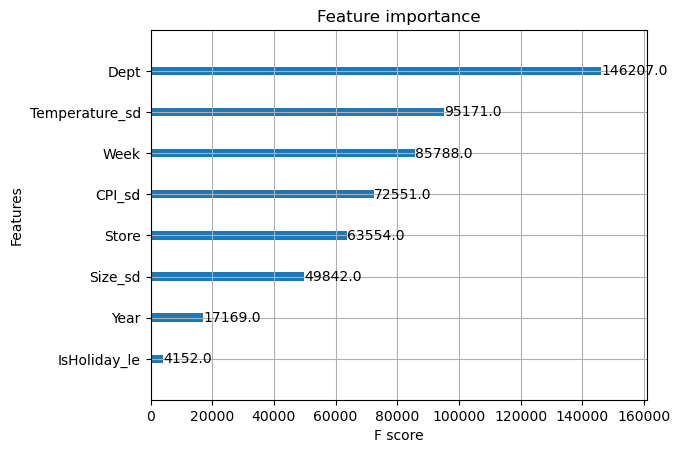

In [232]:
import xgboost as xgb
xgb.plot_importance(model_xgb9);

### 시간 측정

In [136]:
rf7 = RandomForestRegressor(random_state=73)

In [137]:
start = time.time()
rf7.fit(X_train, y_train)
print("time :", time.time() - start)

time : 95.14946460723877


In [138]:
start = time.time()
rf7.predict(X_test)
print("time :", time.time() - start)

time : 3.7764341831207275


In [139]:
params = {'alpha': 2,
          'colsample_bytree': 0.9,
          'lambda': 10,
          'learning_rate': 0.3,
          'max_depth': 10,
          'min_child_weight': 5,
          'n_estimators': 1000, 
          'random_state': 73}

model_xgb9 = XGBRegressor(**params)

In [140]:
start = time.time()
model_xgb9.fit(X_train, y_train)
print("time :", time.time() - start)

time : 5.607545614242554


In [141]:
start = time.time()
model_xgb9.predict(X_test)
print("time :", time.time() - start)

time : 0.3647787570953369


### 최종 모델용 csv 추출

In [17]:
model_X = df[['Store','Dept','Year','Week','IsHoliday_le','Size_sd',
              'Temperature_sd','CPI_sd','Weekly_Sales']]
model_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Store           421570 non-null  int64  
 1   Dept            421570 non-null  int64  
 2   Year            421570 non-null  int64  
 3   Week            421570 non-null  int64  
 4   IsHoliday_le    421570 non-null  int64  
 5   Size_sd         421570 non-null  float64
 6   Temperature_sd  421570 non-null  float64
 7   CPI_sd          421570 non-null  float64
 8   Weekly_Sales    421570 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 28.9 MB


In [14]:
model_X.to_csv('./data/model_X.csv', index=False)

In [145]:
model_X.head()

,Store,Dept,Year,Week,IsHoliday_le,Size_sd,Temperature_sd,CPI_sd,Weekly_Sales
0,1,1,2010,5,0,0.333175,-0.912661,0.972312,24924.50
1,1,2,2010,5,0,0.333175,-0.912661,0.972312,50605.27
2,1,3,2010,5,0,0.333175,-0.912661,0.972312,13740.12
3,1,4,2010,5,0,0.333175,-0.912661,0.972312,39954.04
4,1,5,2010,5,0,0.333175,-0.912661,0.972312,32229.38


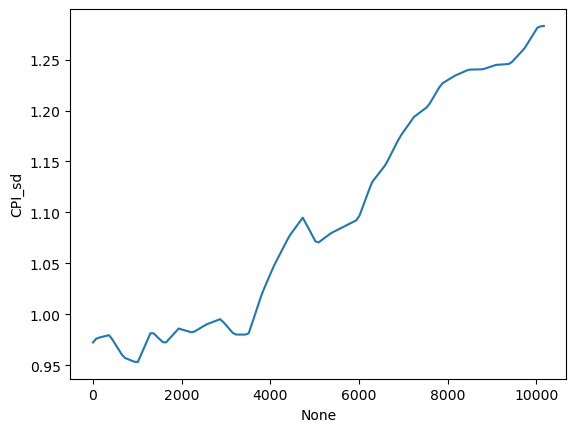

In [146]:
st1 = model_X[(model_X['Store']==1) & (model_X['Dept']==1)]
sns.lineplot(st1, x=st1.index, y='CPI_sd');

In [15]:
# from os import path
# import pickle 

# pkl_filename = "./rf_model.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk 
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(model_rf, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

Model already saved


In [147]:
import pickle
with open('xgb_revolution_last.pkl', 'wb') as f:
    pickle.dump(model_xgb9, f)

In [ ]:
model_xgb

## 기타

### 파트

In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(X_train)

In [ ]:
X.head(15)

In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(df[['Store','Dept','Temperature','CPI']]);

In [54]:
from sklearn.ensemble import VotingRegressor

models = [('rf',model_rf_c),('xgb',model_xgb2)]
voting_regressor = VotingRegressor(models,weights=[0.404,0.596])

voting_regressor.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(min_samples_leaf=12,
                                                   min_samples_split=8,
                                                   n_estimators=300,
                                                   random_state=73)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.9, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_...
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.3, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=10,
                                          max_leaves=None, min_child_weight=5,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=630,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=73, ...))],
                weights=[0.404, 0.596])

In [56]:
y_pred = voting_regressor.predict(X_test)

In [57]:
get_score(voting_regressor, y_test, y_pred)

VotingRegressor
WMAE : 1444.8953
RMSE : 3141.3177
R2 : 0.9808
ER(low,high) : (17.0188, 0.0643)  기준 : 30000


In [58]:
y_pred_train = voting_regressor.predict(X_train)

In [59]:
get_score(voting_regressor, y_train, y_pred_train)

VotingRegressor
WMAE : 0.0
RMSE : 1838.0761
R2 : 0.9935
ER(low,high) : (11.1238, 0.0406)  기준 : 30000


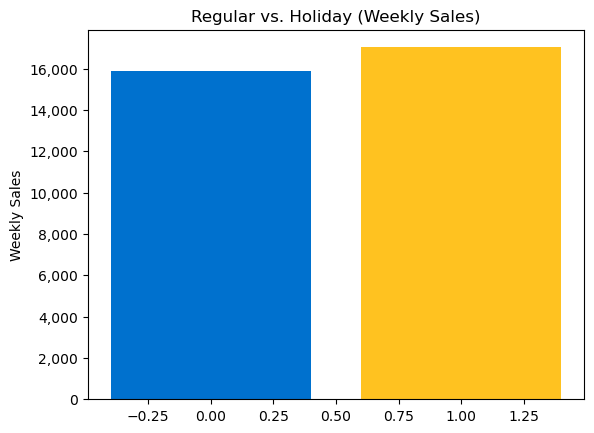

In [19]:
t2 = df.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()

# seaborn의 barplot을 사용하여 그래프 그리기
plt.bar(t2['IsHoliday'], t2['Weekly_Sales'], color=['#0071ce', '#ffc220'])
plt.title('Regular vs. Holiday (Weekly Sales)')
plt.ylabel('Weekly Sales')  # y 축 레이블 설정

# y 축의 눈금 값들에 천 단위 쉼표 추가하기
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.show()

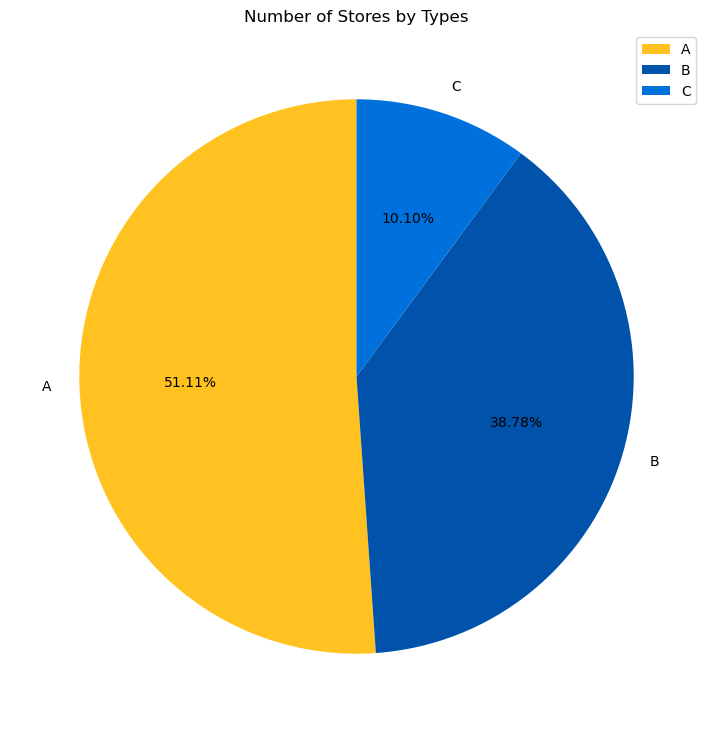

In [14]:
cnt_type = wal_df.groupby(['Type'])['Store'].count().reset_index()
# store type 별 store의 수
palette_pie = ['#FFC220','#0052AA','#0071DC']
plt.figure(figsize=(9,9))
plt.pie(cnt_type['Store'],labels=cnt_type['Type'], autopct='%1.2f%%', 
        startangle = 90, colors=palette_pie)
plt.title('Number of Stores by Types')
plt.legend()
plt.show()

### 원핫

In [18]:
model_X

,Store,Dept,Year,Week,IsHoliday_le,Size_sd,Temperature_sd,CPI_sd,Weekly_Sales
0,1,1,2010,5,0,0.333175,-0.912661,0.972312,24924.50
1,1,2,2010,5,0,0.333175,-0.912661,0.972312,50605.27
2,1,3,2010,5,0,0.333175,-0.912661,0.972312,13740.12
3,1,4,2010,5,0,0.333175,-0.912661,0.972312,39954.04
4,1,5,2010,5,0,0.333175,-0.912661,0.972312,32229.38
...,...,...,...,...,...,...,...,...,...
421565,45,93,2012,43,0,-0.191193,-0.027102,0.499502,2487.80
421566,45,94,2012,43,0,-0.191193,-0.027102,0.499502,5203.31
421567,45,95,2012,43,0,-0.191193,-0.027102,0.499502,56017.47
421568,45,97,2012,43,0,-0.191193,-0.027102,0.499502,6817.48


In [19]:
from sklearn.preprocessing import OneHotEncoder
oe1 = OneHotEncoder()
oe2 = OneHotEncoder()
a = oe1.fit_transform(model_X[['Store']])
b = oe2.fit_transform(model_X[['Dept']])

In [20]:
a_df = pd.DataFrame(a.toarray(), columns = oe1.get_feature_names_out())
a_df

,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
421566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
421567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
421568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
b_df = pd.DataFrame(b.toarray(), columns = oe2.get_feature_names_out())
b_df

,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Dept_7,Dept_8,Dept_9,Dept_10,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
421566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
421567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
421568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
XX = pd.concat([model_X.iloc[:,2:],a_df,b_df], axis = 1)
XX.head()

,Year,Week,IsHoliday_le,Size_sd,Temperature_sd,CPI_sd,Weekly_Sales,Store_1,Store_2,Store_3,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,2010,5,0,0.333175,-0.912661,0.972312,24924.50,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010,5,0,0.333175,-0.912661,0.972312,50605.27,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010,5,0,0.333175,-0.912661,0.972312,13740.12,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010,5,0,0.333175,-0.912661,0.972312,39954.04,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010,5,0,0.333175,-0.912661,0.972312,32229.38,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# 데이터셋 분리
X = XX.drop('Weekly_Sales', axis=1)
y = XX['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(295099, 132) (126471, 132) (295099,) (126471,)


In [27]:
model_xgb12 = XGBRegressor(random_state=73)

model_xgb12.fit(X_train, y_train)

y_pred = model_xgb12.predict(X_test)
y_pred_train = model_xgb12.predict(X_train)

get_score(model_xgb12, y_train, y_pred_train, X_train)
get_score(model_xgb12, y_test, y_pred, X_test)

XGBRegressor
WMAE : 3356.0205
RMSE : 5533.4648
R2 : 0.9408
ER(low,high) : (73.365, 0.1435)  기준 : 30000
XGBRegressor
WMAE : 3402.8074
RMSE : 5746.3508
R2 : 0.9356
ER(low,high) : (78.9698, 0.146)  기준 : 30000


In [178]:
params = {'alpha': 2,
          'colsample_bytree': 0.9,
          'lambda': 10,
          'learning_rate': 0.3,
          'max_depth': 10,
          'min_child_weight': 5,
          'n_estimators': 1000, 
          'random_state': 73}

model_xgb10 = XGBRegressor(**params)

model_xgb10.fit(X_train, y_train)

y_pred = model_xgb10.predict(X_test)
y_pred_train = model_xgb10.predict(X_train)

get_score(model_xgb10, y_train, y_pred_train, X_test)
get_score(model_xgb10, y_test, y_pred, X_test)

XGBRegressor
WMAE : 0.0
RMSE : 1309.3358
R2 : 0.9967
ER(low,high) : (15.222, 0.0319)  기준 : 30000
XGBRegressor
WMAE : 1406.4817
RMSE : 2901.2619
R2 : 0.9836
ER(low,high) : (21.1621, 0.0612)  기준 : 30000


In [179]:
X = model_X.iloc[:,:-1]
y = model_X['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=df['IsHoliday'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(295099, 8) (126471, 8) (295099,) (126471,)


In [186]:
params = {'alpha': 2,
          'colsample_bytree': 0.9,
          'lambda': 10,
          'learning_rate': 0.3,
          'max_depth': 10,
          'min_child_weight': 5,
          'n_estimators': 1300, 
          'random_state': 73}

model_xgb11 = XGBRegressor(**params)

model_xgb11.fit(X_train, y_train)

y_pred = model_xgb11.predict(X_test)
y_pred_train = model_xgb11.predict(X_train)

get_score(model_xgb11, y_train, y_pred_train, X_test)
get_score(model_xgb11, y_test, y_pred, X_test)

XGBRegressor
WMAE : 0.0
RMSE : 801.1896
R2 : 0.9988
ER(low,high) : (8.6085, 0.0186)  기준 : 30000
XGBRegressor
WMAE : 1381.2745
RMSE : 2650.7579
R2 : 0.9863
ER(low,high) : (24.1293, 0.057)  기준 : 30000


In [13]:
df[['Store','Dept','Year_le','Month','Day','IsHoliday_le','Temperature_sd','Fuel_Price_sd','CPI_sd','Unemployment_sd']]


,Store,Dept,Year_le,Month,Day,IsHoliday_le,Temperature_sd,Fuel_Price_sd,CPI_sd,Unemployment_sd
0,1,1,0,2,5,0,-0.912661,-1.933624,0.972312,0.148726
1,1,2,0,2,5,0,-0.912661,-1.933624,0.972312,0.148726
2,1,3,0,2,5,0,-0.912661,-1.933624,0.972312,0.148726
3,1,4,0,2,5,0,-0.912661,-1.933624,0.972312,0.148726
4,1,5,0,2,5,0,-0.912661,-1.933624,0.972312,0.148726
...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2,10,26,0,-0.027102,1.103633,0.499502,0.447586
421566,45,94,2,10,26,0,-0.027102,1.103633,0.499502,0.447586
421567,45,95,2,10,26,0,-0.027102,1.103633,0.499502,0.447586
421568,45,97,2,10,26,0,-0.027102,1.103633,0.499502,0.447586
